In [1]:
import json
import random
import sys

sys.path.insert(1, '../../src')

from ce.algorithms.greedy_heuristics import greedy_cycle, random_solution
from ce.algorithms.local_search import greedy_local_search, steepest_local_search, two_edges_neighborhood, two_nodes_neighborhood
from ce.tsp_optimized import create_tsp, TSP
from ce.utils.experiments import run_all_experiments

random.seed(13)

# Local Search

**Nina Zukowska 148278, Antoni Solarski 148270**

In [2]:
problem_instance_A_path = '../../data/TSPA.csv'
problem_instance_B_path = '../../data/TSPB.csv'
problem_instance_C_path = '../../data/TSPC.csv'
problem_instance_D_path = '../../data/TSPD.csv'

In [3]:
tspa, tspb, tspc, tspd = create_tsp(problem_instance_A_path), create_tsp(problem_instance_B_path), create_tsp(problem_instance_C_path), create_tsp(problem_instance_D_path)

## Algorithms

### Initial solution generation

We used two methods implemented previously:
- *random solution*
- *greedy cycle*

---

### Next solution generation

For each of the methods we implemented three different functions to:
- generate all possible 'moves' that creates new solution
- calculate a cost difference for a given move
- construct new solution for a given move

#### Inter route

```python
def inter_route_moves(solution: List[int], tsp: TSP):
    # replace any node of the solution with any node from the rest
    # return pair (position_to_replace, node_idx_to_insert)
    outer_nodes = [i for i in tsp.indexes if i not in solution]
    for i, _ in enumerate(solution):
        for n in outer_nodes:
            yield i, n


def inter_route_cost_delta(solution: List[int], move: Tuple[int, int], tsp: TSP) -> int:
    i, outer_node = move
    node_to_replace = solution[i]
    before, after = solution[(i - 1) % len(solution)], solution[(i + 1) % len(solution)]

    return (
            + tsp.nodes[outer_node].cost - tsp.nodes[node_to_replace].cost
            + tsp.distances[before, outer_node] + tsp.distances[outer_node, after]
            - tsp.distances[before, node_to_replace] - tsp.distances[after, node_to_replace]
    )


def inter_route_new_solution(solution: List[int], move: Tuple[int, int]) -> List[int]:
    i, outer_node = move
    return solution[:i] + [outer_node] + solution[i + 1:]ut``n[replacement + 1:]
```

#### 2-nodes exchange

```python
def two_nodes_moves(solution: List[int]):
    # exchange position of any two nodes
    # return pair (position_1, position_2)
    for i, _ in enumerate(solution):
        for j, _ in enumerate(solution):
            # first node is fixed to not generate different (but same) neighbors
            if 0 < i < j:
                yield i, j


def two_nodes_cost_delta(solution: List[int], move: Tuple[int, int], tsp: TSP) -> int:
    i, j = move
    node1, node2 = solution[i], solution[j]
    before1, after1 = solution[(i - 1) % len(solution)], solution[(i + 1) % len(solution)]
    before2, after2 = solution[(j - 1) % len(solution)], solution[(j + 1) % len(solution)]

    return (
            + tsp.distances[before1, node2] + tsp.distances[node2, after1]
            + tsp.distances[before2, node1] + tsp.distances[node1, after2]
            - tsp.distances[before1, node1] - tsp.distances[node1, after1]
            - tsp.distances[before2, node2] - tsp.distances[node2, after2]
    )


def two_nodes_new_solution(solution: List[int], move: Tuple[int, int]) -> List[int]:
    i, j = move
    return solution[:i] + [solution[j]] + solution[i + 1:j] + [solution[i]] + solution[j + 1:]
```i]] + solution[j + 1:]
```

### 2-edges exchange

```python
def two_edges_moves(solution: List[int]):
    # exchange position of any two edges
    # return pair (position_of_edge_1, position_of_edge_2)
    # edge nr i connects nodes i and i+1
    for i, _ in enumerate(solution):
        for j, _ in enumerate(solution):
            # no point in exchanging adjacent edges
            if i < j and (j - i) > 1 and not (i == 0 and j == len(solution) - 1):
                yield i, j


def two_edges_cost_delta(solution: List[int], move: Tuple[int, int], tsp: TSP) -> int:
    i, j = move
    from1, to1 = solution[i], solution[(i + 1) % len(solution)]
    from2, to2 = solution[j], solution[(j + 1) % len(solution)]
    return (
            - tsp.distances[from1, to1] - tsp.distances[from2, to2]
            + tsp.distances[from1, from2] + tsp.distances[to1, to2]
    )


def two_edges_new_solution(solution: List[int], move: Tuple[int, int]) -> List[int]:
    i, j = move
    return solution[:i + 1] + solution[j:i:-1] + solution[j + 1:]
```

---

### Steepest local search

```python
def steepest_local_search(tsp: TSP, init_solution, neighborhood) -> List[int]:
    solution = init_solution
    local_optimum = False

    while not local_optimum:
        best_neighbor = min(neighborhood(solution, tsp), key=lambda x: get_cost_delta(x, solution, tsp))
        if get_cost_delta(best_neighbor, solution, tsp) < 0:
            solution = get_new_solution(best_neighbor, solution)
        else:
            local_optimum = True

    return solution
```

---

### Greedy local search

```python
def greedy_local_search(tsp: TSP, init_solution, neighborhood) -> List[int]:
    solution = init_solution
    local_optimum = False

    while not local_optimum:
        step_done = False

        for neighbor in neighborhood(solution, tsp):
            cost_delta = get_cost_delta(neighbor, solution, tsp)
            if cost_delta < 0:
                solution = get_new_solution(neighbor, solution)
                step_done = True
                break

        if not step_done:
            local_optimum = True

    return solution
```

---

## Experiments

In [4]:
experiments = [
    "G_r_2n",
    "G_r_2e",
    "S_r_2n",
    "S_r_2e",
    "G_c_2n",
    "G_c_2e",
    "S_c_2n",
    "S_c_2e",
]

def experiments_provider(tsp: TSP, random_inits):
    return [
        lambda x: greedy_local_search(tsp, random_inits[x], two_nodes_neighborhood),
        lambda x: greedy_local_search(tsp, random_inits[x], two_edges_neighborhood),
        lambda x: steepest_local_search(tsp, random_inits[x], two_nodes_neighborhood),
        lambda x: steepest_local_search(tsp, random_inits[x], two_edges_neighborhood),
        lambda x: greedy_local_search(tsp, greedy_cycle(tsp, x), two_nodes_neighborhood),
        lambda x: greedy_local_search(tsp, greedy_cycle(tsp, x), two_edges_neighborhood),
        lambda x: steepest_local_search(tsp, greedy_cycle(tsp, x), two_nodes_neighborhood),
        lambda x: steepest_local_search(tsp, greedy_cycle(tsp, x), two_edges_neighborhood),
    ]

### Instance C

In [5]:
random_inits_c = [random_solution(tspc) for i in range(200)]

**************************************************************************************************
G_r_2n:	cost: AVG 63926.18, (57190.00 - 71065.00)	time: AVG 3.69s, (2.78s - 4.73s)
G_r_2e:	cost: AVG 51537.64, (49356.00 - 54744.00)	time: AVG 3.65s, (2.94s - 4.89s)
S_r_2n:	cost: AVG 66427.05, (59656.00 - 73381.00)	time: AVG 4.21s, (1.13s - 6.19s)
S_r_2e:	cost: AVG 51539.82, (49044.00 - 54523.00)	time: AVG 3.24s, (2.62s - 3.87s)
G_c_2n:	cost: AVG 55506.56, (53130.00 - 58435.00)	time: AVG 1.03s, (0.94s - 1.21s)
G_c_2e:	cost: AVG 55039.97, (53080.00 - 58194.00)	time: AVG 1.07s, (0.94s - 1.26s)
S_c_2n:	cost: AVG 55534.82, (53130.00 - 58435.00)	time: AVG 1.04s, (0.93s - 1.38s)
S_c_2e:	cost: AVG 55002.71, (52984.00 - 58194.00)	time: AVG 1.19s, (0.96s - 1.52s)
**************************************************************************************************




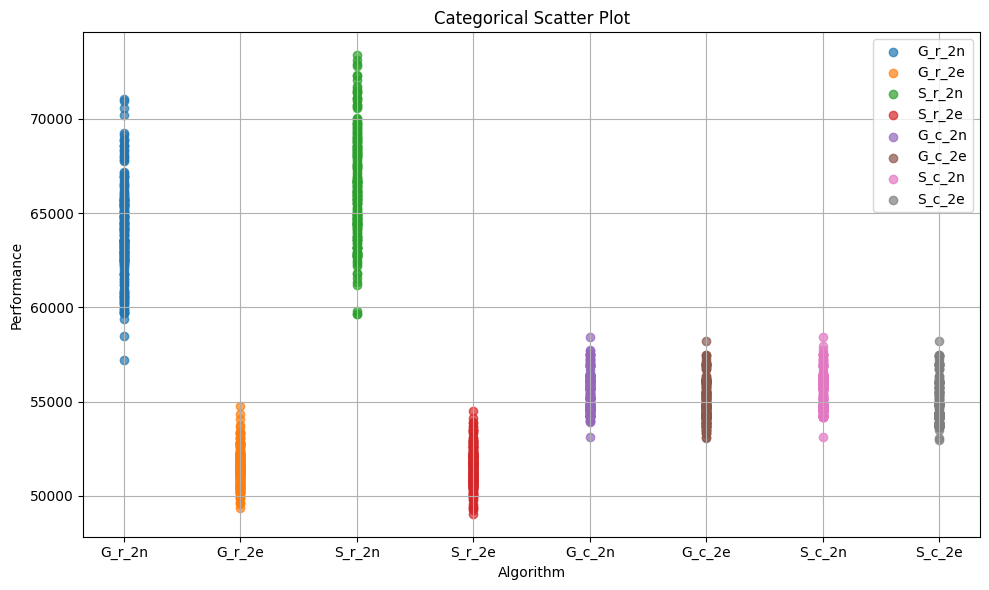

CPU times: total: 1h 3min 47s
Wall time: 1h 3min 43s


In [6]:
%%time
best_solutions_c, results_list_c = run_all_experiments(200, experiments_provider(tspc, random_inits_c), tspc.get_solution_cost, experiments)

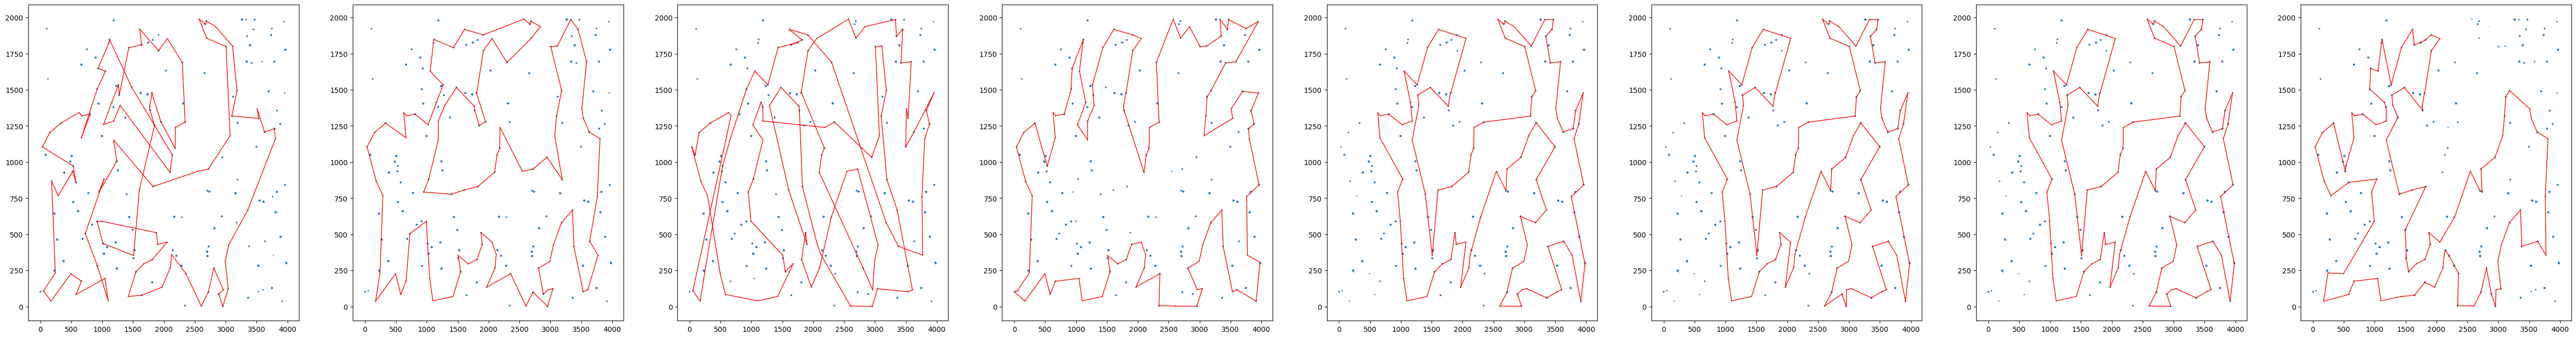

In [7]:
tspc.plot(best_solutions_c)

### Instance D

In [12]:
random_inits_d = [random_solution(tspd) for i in range(200)]

**************************************************************************************************
G_r_2n:	cost: AVG 62443.75, (55664.00 - 72279.00)	time: AVG 3.59s, (3.00s - 4.36s)
G_r_2e:	cost: AVG 48601.78, (45801.00 - 51179.00)	time: AVG 3.62s, (3.18s - 4.13s)
S_r_2n:	cost: AVG 65059.50, (55535.00 - 74716.00)	time: AVG 4.05s, (3.09s - 5.14s)
S_r_2e:	cost: AVG 48223.22, (45617.00 - 51009.00)	time: AVG 3.17s, (2.71s - 3.81s)
G_c_2n:	cost: AVG 54631.68, (50074.00 - 60913.00)	time: AVG 0.98s, (0.93s - 1.34s)
G_c_2e:	cost: AVG 54164.86, (49536.00 - 60187.00)	time: AVG 1.06s, (0.96s - 1.38s)
S_c_2n:	cost: AVG 54571.79, (50018.00 - 60913.00)	time: AVG 1.02s, (0.91s - 1.40s)
S_c_2e:	cost: AVG 54120.19, (49536.00 - 60140.00)	time: AVG 1.17s, (1.00s - 1.37s)
**************************************************************************************************




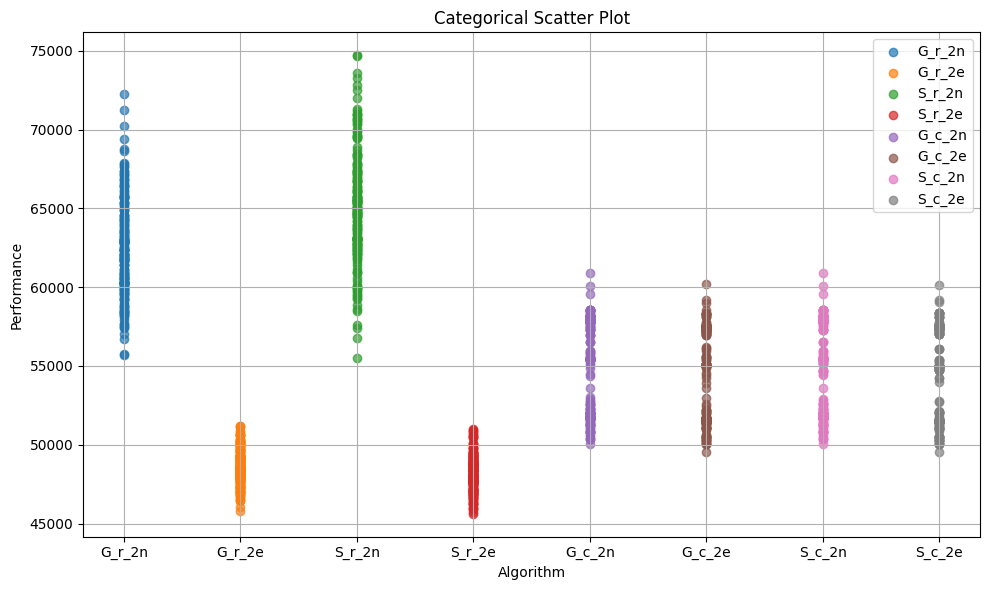

CPU times: total: 1h 2min 12s
Wall time: 1h 2min 12s


In [13]:
%%time
best_solutions_d, results_list_d = run_all_experiments(200, experiments_provider(tspd, random_inits_d), tspd.get_solution_cost, experiments)

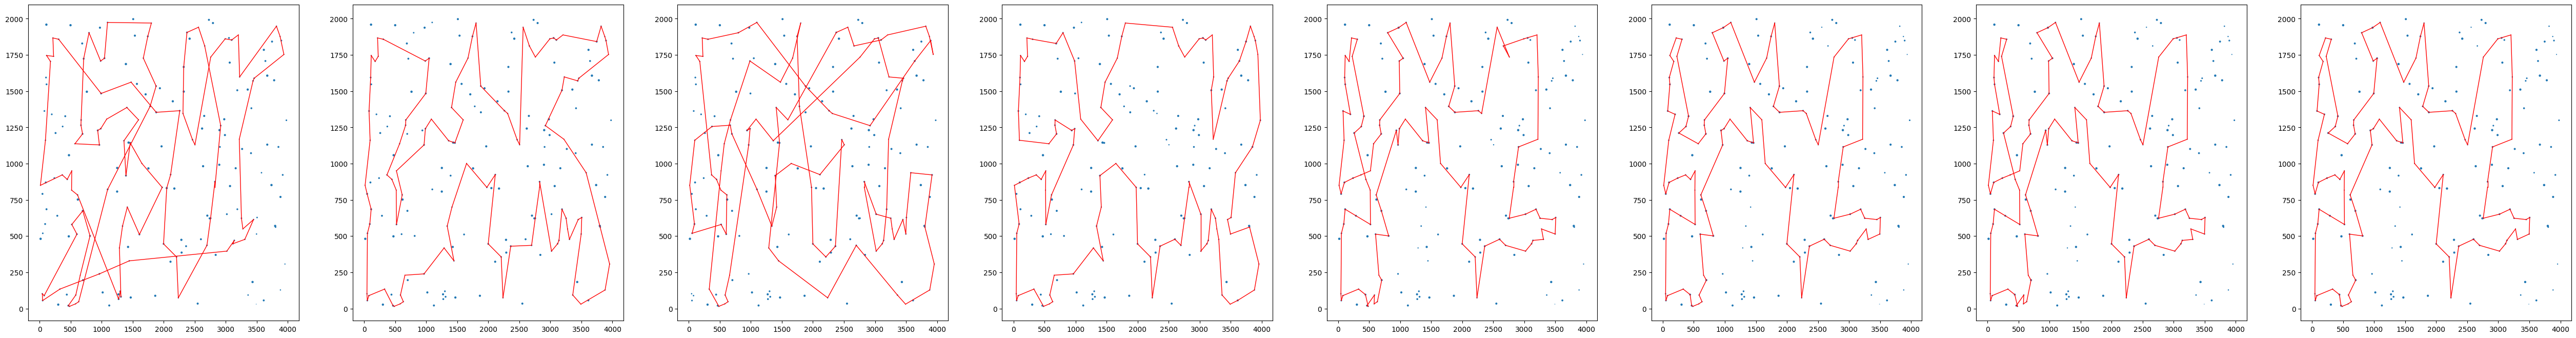

In [14]:
tspd.plot(best_solutions_d)

In [8]:
with open('results_c.json', 'w', encoding='utf-8') as f:
    json.dump(results_list_c, f, ensure_ascii=False, indent=4)
with open('best_solutions_c.json', 'w', encoding='utf-8') as f:
    json.dump(best_solutions_c, f, ensure_ascii=False, indent=4)

In [15]:
with open('results_d.json', 'w', encoding='utf-8') as f:
    json.dump(results_list_d, f, ensure_ascii=False, indent=4)
with open('best_solutions_d.json', 'w', encoding='utf-8') as f:
    json.dump(best_solutions_d, f, ensure_ascii=False, indent=4)

## Conclusions

- The 2-edge neighborhood outperformed the 2-node neighborhood (significantly on a random initial solution - no clear difference for a greedy cycle as an initial solution).
- Experiments with the greedy cycle as an initial solution were much faster as fewer searches were done before achieving local optima. That's along with intuition as there is little flexibility in improving an already formed greedy cycle contrary to the random solution.
- There is no big difference between the steepest and greedy local search in cost or time. (Remark about the time - as the whole neighborhood was generated to randomize choosing the next step time wasn't shorter in case of greedy local search. In theory, only as many neighbors as needed to do the next step could be generated to speed up searching - but it makes randomized neighbor choice really difficult.)
- Best results were achieved with a 2-edge neighborhood and random initial solution. The superior results of the random initial solution than the greedy cycle were probably caused by less flexibility in improving the greedy cycle and getting trapped in local optima pretty quickly. However, this is the case only for 2-edge neighborhoods as for 2-node the results with random initial solution were worse than for greedy cycle one.   